# **Assignment - Part1**

## GRADCAM

Let's start with a pretrained VGG model

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

Using TensorFlow backend.


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [2]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0702 16:35:43.629282 140474698663808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 16:35:43.667051 140474698663808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 16:35:43.673222 140474698663808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 16:35:43.707630 140474698663808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 6s 0us/step


W0702 16:35:50.134576 140474698663808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0702 16:35:50.135717 140474698663808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

### GradCAM for last layer, one layer before the last layer & two layers before the last layer of VGG16

In [0]:
# Function to obtain class_output from the predictions. Model, processed image and layer_name need to be passed as arguments

def pred_class_info(model, x, layer_name):
      preds = model.predict(x)
      class_idx = np.argmax(preds[0])
      print(class_idx)
      class_output = model.output[:, class_idx]
      last_conv_layer = model.get_layer(layer_name)
      return class_output,last_conv_layer

1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [0]:
# Import numpy, cv2, sys, Keras image and backend
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys



# Function to obtain weighted features map. This takes class ouput, last convoultion layer, image and number of filters as arguments

  
def weighted_feature_map(model, class_output, last_conv_layer, x, filters):
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(filters):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  return conv_layer_output_value

1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [0]:
# Function to generate heatmap from pooled_gradient_values * conv_layer_output

def gen_heatmap(conv_layer_output_value):
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  print(conv_layer_output_value.shape)
  print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

Show the results

block5_conv3
0
180
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


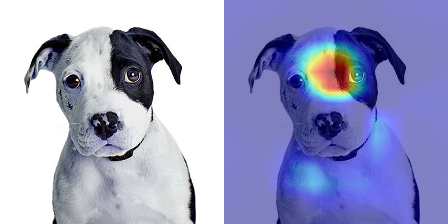


block5_conv2
1
180
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


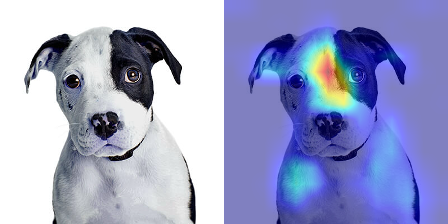


block5_conv1
2
180
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


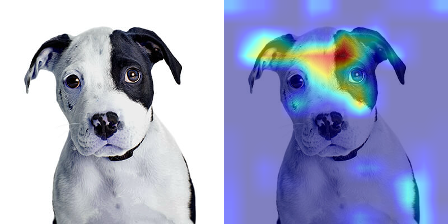

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def grad_CAM(model, x, layer_name, num_filters):
  class_output,last_conv_layer = pred_class_info(model, x, layer_name)
  conv_layer_output_value = weighted_feature_map(model, class_output, last_conv_layer, x, num_filters)
  return gen_heatmap(conv_layer_output_value)


layers = ["block5_conv3","block5_conv2","block5_conv1"]

#fig=plt.figure()
#spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

for idx,lyr in enumerate(layers):
  print(lyr)
  print(idx)
  heatmap = grad_CAM(model, x, lyr, 512)
  heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
  #numpy_horizontal = np.hstack((image, grey_3_channel))
  numpy_horizontal_concat = np.concatenate((dog, superimposed_img), axis=1)
  from google.colab.patches import cv2_imshow
  cv2_imshow(numpy_horizontal_concat)
  print()

### Find "sunglasses" in the image from the URL [tonystark ](https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg)

In [0]:
# Import libraries

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

In [13]:
# Mount google drive into colab. This is to save snapshots of the model during training

from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [14]:
# Download the image

!wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
  
filepath="/content/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg"



--2019-07-02 16:39:53--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.244.83, 190.93.245.83, 190.93.247.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.244.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.03s   

2019-07-02 16:39:53 (2.12 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’ saved [58670/58670]



In [0]:
model = VGG16(weights="imagenet")
from skimage import io
tony_stark = io.imread(filepath)


tony_stark = cv2.resize(tony_stark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tony_stark)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [16]:
# preds = model.predict(x)
class_idx = 837
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

837


In [17]:
# Import numpy, cv2, sys, Keras image and backend
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [18]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


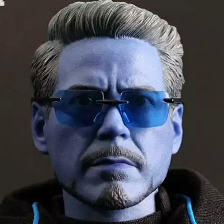

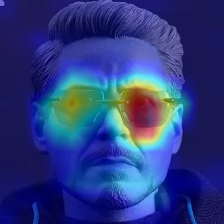

In [19]:
heatmap = cv2.resize(heatmap, (tony_stark.shape[1], tony_stark.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(tony_stark, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( tony_stark)
cv2_imshow(superimposed_img)

# **Assignment - Part2**

### Explaination for the increase of Receptive field from 29 to 45 in table 7 of page 21 in https://arxiv.org/pdf/1701.03056.pdf 

| Convolution | Input        | Output          | Receptive Field | Features |
| ----------- | ------------ | --------------- | --------------- | -------- |
| 1           | 128x128x96   | 128x128x96      | 3x3x3           | 8        |
| 2           | 128x128x96   | 64x64x48        | 5x5x5           | 8        |
| 3           | 64x64x48     | 64x64x48        | 9x9x9           | 16       |
| 4           | 64x64x48     | 32x32x24        | 13x13x13        | 32       |
| 5           | 32x32x24     | 32x32x24        | 21x21x21        | 32       |
| 6           | 32x32x24     | 16x16x12        | 29x29x29        | 64       |
|             | **End of**   | **Contracting** | **path**        |          |
| 7           | 16x16x12     | 16x16x12        | 45x45x45        | 64       |
|             | **Begin of** | **expanding**   | **path**        |          |
| 9           | 16x16x12     | 32x32x24        | 53x53x53        | 32       |
| 10          | 32x32x24     | 32x32x24        | 61x61x61        | 64       |
| 12          | 32x32x24     | 64x64x48        | 65x65x65        | 16       |
| 13          | 64x64x48     | 64x64x48        | 69x69x69        | 32       |
| 15          | 64x64x48     | 128x128x96      | 71x71x71        | 8        |
| 16          | 128x128x96   | 128x128x96      | 73x73x73        | 16       |




![fcn](images/fcn_rffc.png)

*   As shown in the diagram above upto convolution 6 in the above table the layers are convolution operation of 3x3 kernel with stride 1 followed by stride 2 convolution/Max Pooling operation. This is known as Contracting block. This will result in a receptive field of 29 at Convolution 6.
*   This is then followed by a single convolution operation i.e. 3x3 convolution with stride 1. This will result in the receptive field increase from 29 to 45 (Calculation : 29 + (3-1) * 8 , 29 is input receptive field, kernel size is 3 and Jump-in is 8)

*   The next 3 layers consist of deconvolution operation followed by convolution. This is known as Expanding block.




### **References & Attributions:**

*   Keras (https://keras.io/)

*   Tensorflow 2.1 (https://www.tensorflow.org/api_docs/python/)


*Disclaimer: The contents of this notebook are used for educational purposes i.e. for learning and research.*